In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/FruitVeg/

/content/drive/MyDrive/FruitVeg


In [ ]:
%ls

test/  train/  validation/


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from pathlib import Path


In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
drive_path = '/content/drive'
data_path = Path(drive_path) / 'My Drive' / 'FruitVeg' / 'train'
train_filepaths = list(data_path.glob('**/*.jpg'))


In [ ]:
drive_path = '/content/drive'
data_path = Path(drive_path) / 'My Drive' / 'FruitVeg' / 'test'
test_filepaths = list(data_path.glob('**/*.jpg'))

In [ ]:
drive_path = '/content/drive'
data_path = Path(drive_path) / 'My Drive' / 'FruitVeg' / 'validation'
val_filepaths = list(data_path.glob('**/*.jpg'))

In [ ]:
def image_processing(filepath):

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [ ]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['corn' 'pear' 'lettuce' 'banana' 'paprika' 'tomato' 'jalepeno' 'carrot'
 'cucumber' 'peas' 'beetroot' 'soy beans' 'garlic' 'ginger' 'grapes'
 'spinach' 'chilli pepper' 'sweetpotato' 'turnip' 'apple' 'pineapple'
 'mango' 'pomegranate' 'sweetcorn' 'kiwi' 'cabbage' 'eggplant' 'orange'
 'onion' 'bell pepper' 'cauliflower' 'lemon' 'watermelon' 'potato'
 'raddish' 'capsicum']


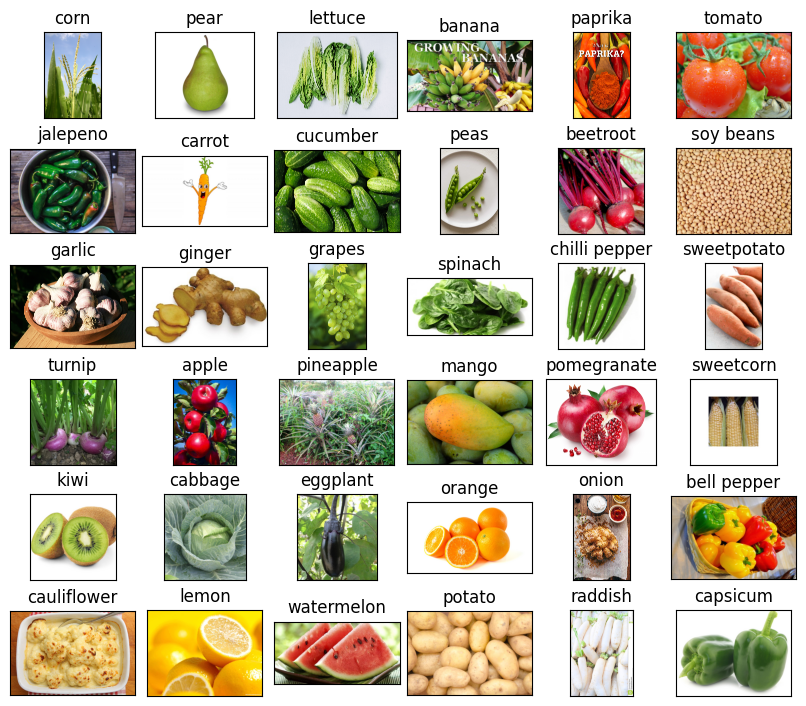

In [ ]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)

plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator
(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator
(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe
(
    dataframe=train_df,

    x_col='Filepath',
    y_col='Label',

    target_size=(224, 224),

    color_mode='rgb',
    class_mode='categorical',

    batch_size=32,
    shuffle=True,
    seed=0,

    rotation_range=30,
    zoom_range=0.15,

    width_shift_range=0.2,
    height_shift_range=0.2,

    shear_range=0.15,
    horizontal_flip=True,

    fill_mode="nearest"
)

Found 2780 validated image filenames belonging to 36 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe
(
    dataframe=val_df,

    x_col='Filepath',
    y_col='Label',

    target_size=(224, 224),

    color_mode='rgb',
    class_mode='categorical',

    batch_size=32,
    shuffle=True,
    seed=0,

    rotation_range=30,
    zoom_range=0.15,

    width_shift_range=0.2,
    height_shift_range=0.2,

    shear_range=0.15,
    horizontal_flip=True,

    fill_mode="nearest"
)

Found 334 validated image filenames belonging to 36 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe
(
    dataframe=test_df,

    x_col='Filepath',
    y_col='Label',

    target_size=(224, 224),

    color_mode='rgb',
    class_mode='categorical',

    batch_size=32,
    shuffle=False
)

Found 334 validated image filenames belonging to 36 classes.


In [ ]:
############## MobileNetV2 ###################

pretrained_model = tf.keras.applications.MobileNetV2
(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
87/87 [==============================] - 769s 9s/step - loss: 1.7478 - accuracy: 0.5309 - val_loss: 0.5021 - val_accuracy: 0.8473
Epoch 2/5
87/87 [==============================] - 244s 3s/step - loss: 0.5495 - accuracy: 0.8259 - val_loss: 0.3147 - val_accuracy: 0.9341
Epoch 3/5
87/87 [==============================] - 245s 3s/step - loss: 0.3354 - accuracy: 0.8953 - val_loss: 0.2334 - val_accuracy: 0.9311
Epoch 4/5
87/87 [==============================] - 239s 3s/step - loss: 0.2149 - accuracy: 0.9327 - val_loss: 0.2135 - val_accuracy: 0.9461
Epoch 5/5
87/87 [==============================] - 241s 3s/step - loss: 0.1495 - accuracy: 0.9518 - val_loss: 0.1930 - val_accuracy: 0.9581


In [ ]:
# Predict the label
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 76s 7s/step


['tomato',
 'bell pepper',
 'onion',
 'cabbage',
 'kiwi',
 'eggplant',
 'pineapple',
 'jalepeno',
 'soy beans',
 'orange',
 'turnip',
 'pear',
 'corn',
 'eggplant',
 'garlic',
 'raddish',
 'potato',
 'watermelon',
 'chilli pepper',
 'orange',
 'ginger',
 'apple',
 'raddish',
 'turnip',
 'orange',
 'pear',
 'raddish',
 'cucumber',
 'lettuce',
 'cabbage',
 'peas',
 'lettuce',
 'turnip',
 'capsicum',
 'pear',
 'beetroot',
 'sweetpotato',
 'apple',
 'sweetcorn',
 'paprika',
 'bell pepper',
 'grapes',
 'bell pepper',
 'pomegranate',
 'carrot',
 'cucumber',
 'lettuce',
 'cucumber',
 'watermelon',
 'potato',
 'paprika',
 'cabbage',
 'pineapple',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'sweetcorn',
 'carrot',
 'pear',
 'raddish',
 'apple',
 'potato',
 'sweetcorn',
 'ginger',
 'cucumber',
 'kiwi',
 'mango',
 'ginger',
 'cabbage',
 'chilli pepper',
 'lettuce',
 'pineapple',
 'sweetpotato',
 'pomegranate',
 'capsicum',
 'potato',
 'garlic',
 'carrot',
 'peas',
 'cucumber',
 'beetroot',
 'eg

In [ ]:
def output(location):

    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])

    answer=model.predict(img)

    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)

    res = labels[y]

    return res

In [ ]:
#Save Model

model.save('Recognition.h5')